# DML ATT Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATT       | Yes        |

We will estimate Average Treatment Effect on Treated (ATT) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Example that generates observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect tau(X). This setup ensures that ATT ≠ ATE in general. It also shows how to compute the “ground-truth” ATT from the generated data.

In [2]:
# Nonlinear ATT data generation with heterogeneous effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalis.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) confounders and their distributions
#    These names define the column order in X for the custom functions.
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices (for convenience inside g_y, g_t, tau)
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
#    Keep a modest linear part and add meaningful nonlinearities.
beta_y = np.array([
    0.03,   # tenure_months
    0.20,   # avg_sessions_week
    0.01,   # spend_last_month
    1.20,   # premium_user
    0.60,   # urban_resident
], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    # Nonlinearities and interactions in outcome baseline
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)          # seasonal-ish tenure pattern
        + 0.02 * (sessions - 5.0) ** 2                    # convex effect of sessions
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)     # spend × sessions interaction
        + 0.4 * premium * (sessions - 5.0)                # premium × sessions interaction
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)   # nonlinear spend effect differs by urban
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_d = np.array([
    0.010,  # tenure_months
    0.12,   # avg_sessions_week
    0.001,  # spend_last_month
    0.80,   # premium_user
    0.25,   # urban_resident
], dtype=float)

def g_d(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Smoothly increasing selection with spend; interactions make selection non-separable
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X) on the natural scale (continuous outcome)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Base effect + stronger effect for higher sessions and premium users,
    # diminishes with tenure, mild modulation by spend and urban
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))    # sigmoid in sessions
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)        # taper with long tenure
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    # Optional: keep it in a reasonable range
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 3.5
target_d_rate = 0.35  # enforce ~35% treated via intercept calibration

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_d_rate=target_d_rate,
    seed=42,
    # confounders
    confounder_specs=confounder_specs,
    # Outcome/treatment structure
    beta_y=beta_y,
    beta_d=beta_d,
    g_y=g_y,
    g_d=g_d,
    # Heterogeneous effect
    tau=tau_fn,
)

# 7) Generate data (full dataframe includes oracle columns: m, m_obs, tau_link, g0, g1, cate;
#    plus legacy aliases: propensity (=m), propensity_obs (=m_obs), mu0 (=g0), mu1 (=g1))
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT (on the natural scale): E[tau(X) | T=1] = mean CATE among the treated
true_att = float(generated_df.loc[generated_df["d"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData for downstream workflows (keeps only y, t, and specified confounders)
causal_data = CausalData(
    df=generated_df,
    treatment="d",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

# Peek at the analysis-ready view
causal_data.df.head()

Ground-truth ATT from the DGP: 1.386


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,2.237316,0.0,27.656605,5.352554,72.552568,1.0,0.0
1,5.771469,0.0,11.520191,6.798247,188.481287,1.0,0.0
2,6.374653,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,2.364177,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,8.378079,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 2}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6530,3.187197,3.754761,-12.770866,-1.579204,0.699571,3.149215,5.720443,7.931635,17.323664
1.0,3470,5.222463,3.986593,-7.310514,0.151741,2.508651,5.205242,7.975189,10.351169,18.147842


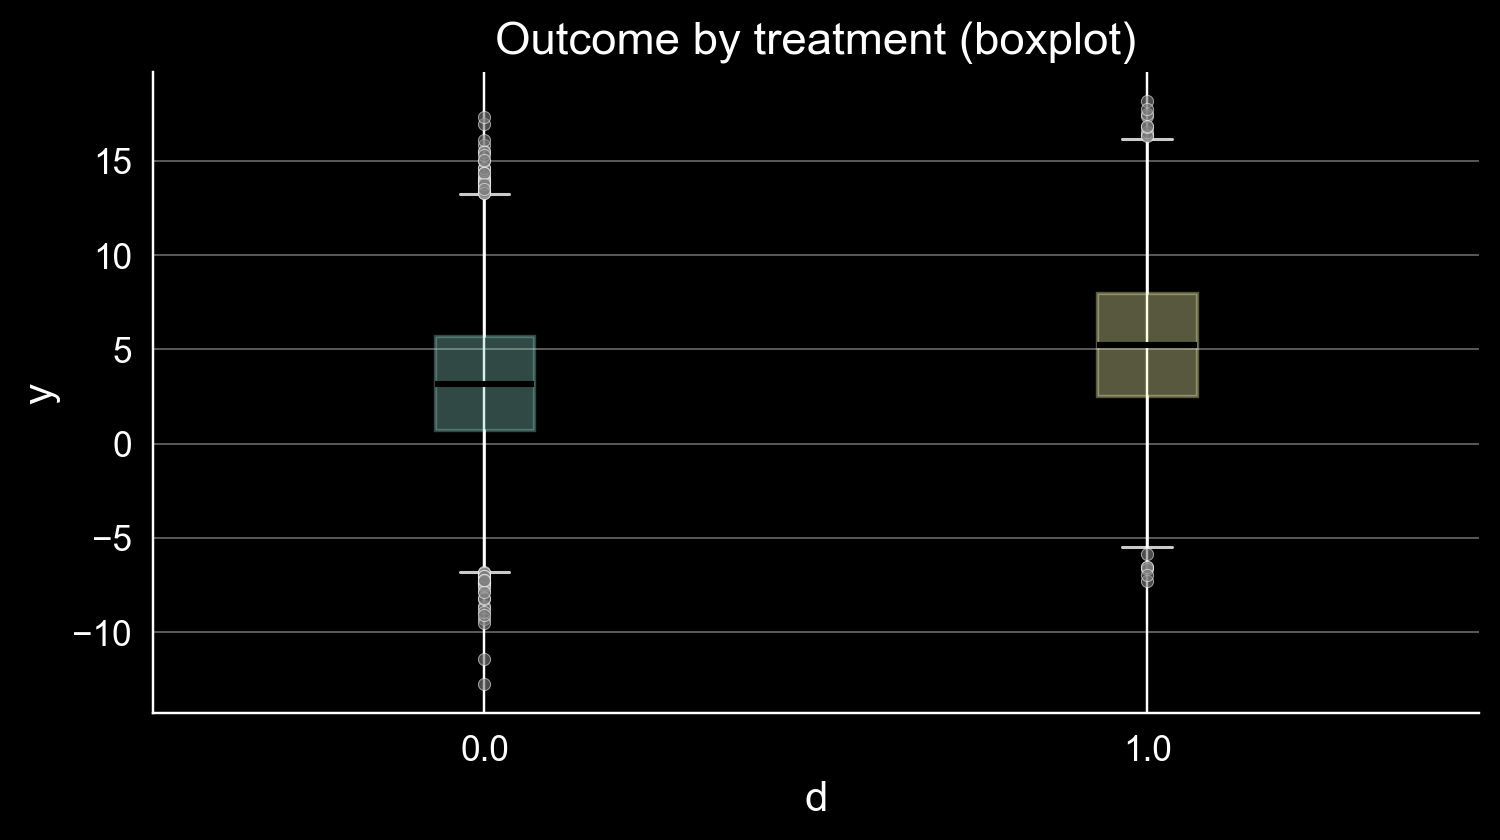

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [1]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

NameError: name 'eda' is not defined

In [ ]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

In [ ]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

In [ ]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

In [ ]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [ ]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

In [ ]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

# Inference

Now time to estimate ATTE with Double Machine Learning

In [7]:
from causalis.inference.atte import dml_atte

# Estimate Average Treatment Effect (ATT)
atte_result = dml_atte(causal_data, n_folds=4, confidence_level=0.95)

AttributeError: 'CausalData' object has no attribute 'cofounders'

In [ ]:
print(atte_result.get('coefficient'))
print(atte_result.get('p_value'))
print(atte_result.get('confidence_interval'))

Real ATT is 1.385

## Refutation

### Overlap

In [ ]:
from  causalis.refutation import *
rep = run_overlap_diagnostics(res=atte_result)
rep["summary"]

### Score

In [ ]:
from causalis.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=atte_result)
rep_score["summary"]

### SUTVA

In [ ]:
print_sutva_questions()

## Uncofoundedness

In [ ]:
from causalis.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=atte_result)
rep_uc['summary']

In [ ]:
from causalis.refutation.uncofoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(atte_result, cf_y=0.01, cf_d=0.01, rho=1.0, level=0.95)

In [ ]:
sensitivity_benchmark(atte_result, benchmarking_set =['tenure_months'])